# Foundations — Copula Visualizations

This notebook generates the figures used in the foundations chapter. All text is in **English** by design.

**Figures produced:**
1. **From Data to U-Space** — scatter panels showing X-space vs U-space for independent, Gaussian, and t-copula patterns.  
2. **U-Space Heatmaps** — density heatmaps highlighting diagonal and corner mass.  
3. **Conceptual Pipeline (Annotated)** — schematic from marginals to pseudo-observations to copula.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, chi2, t as tdist, rankdata

np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")
OUTPUT_DIR = Path('../docs/assets/figures/01_foundations')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print('Saving figures to:', OUTPUT_DIR)

Saving figures to: ..\docs\assets\figures\01_foundations


In [15]:
def to_uniform_by_ranks(x: np.ndarray) -> np.ndarray:
    """Convert each column of x into empirical U(0,1) pseudo-observations via average ranks."""
    u = np.empty_like(x)
    for j in range(x.shape[1]):
        ranks = rankdata(x[:, j], method="average")
        u[:, j] = ranks / (len(x) + 1.0)
    return u

def sample_t_copula(n: int = 4000, rho: float = 0.7, nu: int = 4) -> np.ndarray:
    """Generate pseudo-observations from a t-copula with correlation rho and df nu."""
    cov = np.array([[1.0, rho], [rho, 1.0]])
    z = multivariate_normal(mean=[0, 0], cov=cov).rvs(size=n)
    S = chi2.rvs(df=nu, size=n)
    t_vec = z / np.sqrt(S / nu)[:, None]
    return np.column_stack([
        tdist.cdf(t_vec[:, 0], df=nu),
        tdist.cdf(t_vec[:, 1], df=nu)
    ])

## Figure 1 — From Data to U-Space

This panel shows:
- **X-space (top row)**: raw sample clouds for Independent, Gaussian (ρ=0.7), and t (ν=4, ρ=0.7).  
- **U-space (bottom row)**: empirical uniforms / copula pseudo-observations highlighting the dependence pattern only.

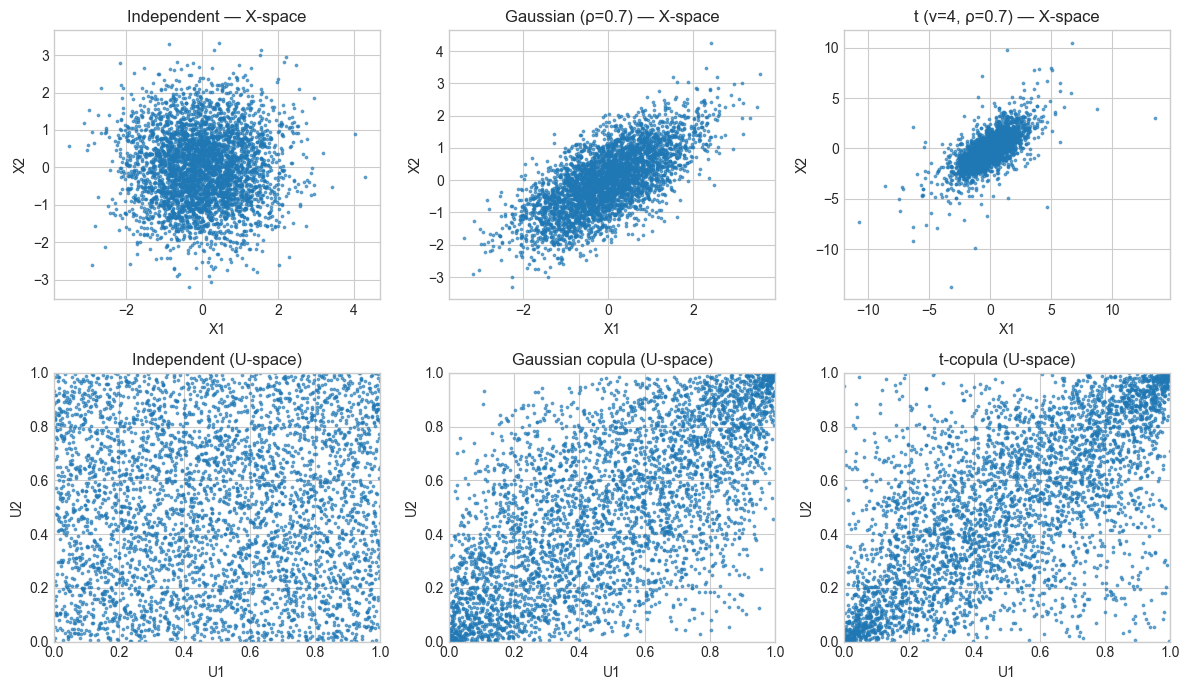

In [17]:
# Generate samples
n = 4000
rho = 0.7
cov = np.array([[1.0, rho], [rho, 1.0]])

x_ind = np.column_stack([np.random.normal(size=n), np.random.normal(size=n)])
x_gauss = multivariate_normal(mean=[0, 0], cov=cov).rvs(size=n)

u_ind = to_uniform_by_ranks(x_ind)
u_gauss = to_uniform_by_ranks(x_gauss)
u_t = sample_t_copula(n=n, rho=rho, nu=4)

# Back-transform t copula U to X-space using t PPF for visualization
x_t_from_u = np.column_stack([tdist.ppf(u_t[:,0], df=4), tdist.ppf(u_t[:,1], df=4)])

# Plot
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes[0, 0].scatter(x_ind[:, 0], x_ind[:, 1], s=3, alpha=0.6); axes[0, 0].set_title("Independent — X-space")
axes[0, 1].scatter(x_gauss[:, 0], x_gauss[:, 1], s=3, alpha=0.6); axes[0, 1].set_title("Gaussian (ρ=0.7) — X-space")
axes[0, 2].scatter(x_t_from_u[:, 0], x_t_from_u[:, 1], s=3, alpha=0.6); axes[0, 2].set_title("t (ν=4, ρ=0.7) — X-space")

for j in range(3):
    axes[0, j].set_xlabel("X1"); axes[0, j].set_ylabel("X2")

datasets_U = [(u_ind, "Independent (U-space)"),
              (u_gauss, "Gaussian copula (U-space)"),
              (u_t, "t-copula (U-space)")]

for j, (udat, title) in enumerate(datasets_U):
    axes[1, j].scatter(udat[:, 0], udat[:, 1], s=3, alpha=0.6)
    axes[1, j].set_title(title)
    axes[1, j].set_xlabel("U1"); axes[1, j].set_ylabel("U2")
    axes[1, j].set_xlim(0, 1); axes[1, j].set_ylim(0, 1)

out = OUTPUT_DIR

plt.tight_layout()
plt.savefig(out / "u_space_overview.png", dpi=200)
plt.savefig(out / "u_space_overview.svg")
plt.show()

## Figure 2 — U-Space Heatmaps

Density heatmaps emphasize concentration along the diagonal (positive dependence) or corners (tail dependence).

C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\2072428952.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


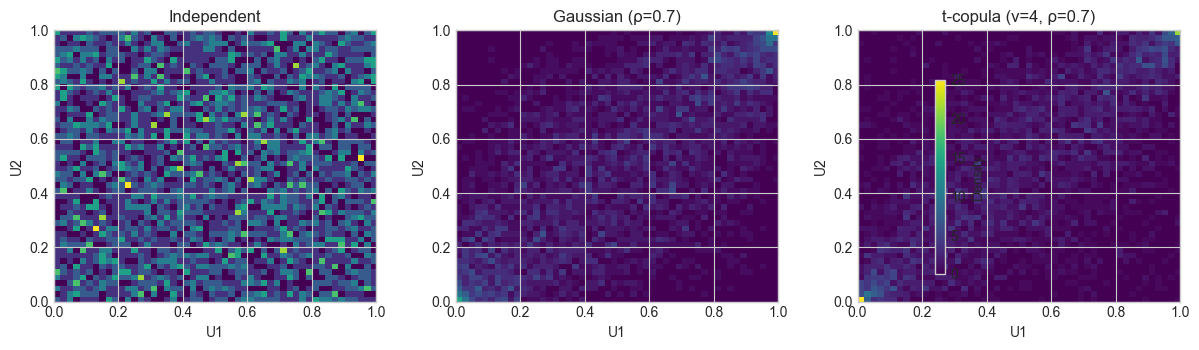

In [24]:
def heat_density(u, bins=60):
    H, _, _ = np.histogram2d(u[:, 0], u[:, 1], bins=bins, range=[[0, 1], [0, 1]], density=True)
    return H.T

datasets = [("Independent", u_ind), ("Gaussian (ρ=0.7)", u_gauss), ("t-copula (ν=4, ρ=0.7)", u_t)]

fig, axes = plt.subplots(1, 3, figsize=(12, 3.6))
last_im = None
for ax, (name, u) in zip(axes, datasets):
    H = heat_density(u, bins=50)
    im = ax.imshow(H, origin="lower", extent=[0, 1, 0, 1], aspect="auto", cmap="viridis")
    ax.set_title(name)
    ax.set_xlabel("U1"); ax.set_ylabel("U2")
    last_im = im

fig.colorbar(last_im, ax=axes.ravel().tolist(), shrink=0.7, label="Density")
plt.tight_layout()
plt.savefig(out / "u_space_heatmaps.png", dpi=200)
plt.savefig(out / "u_space_heatmaps.svg")
plt.show()

# Figure 3 — Conceptual Modeling Pipeline (Annotated)

A schematic highlighting practical steps: marginal fitting, pseudo-observations, copula selection, and U-space diagnostics.

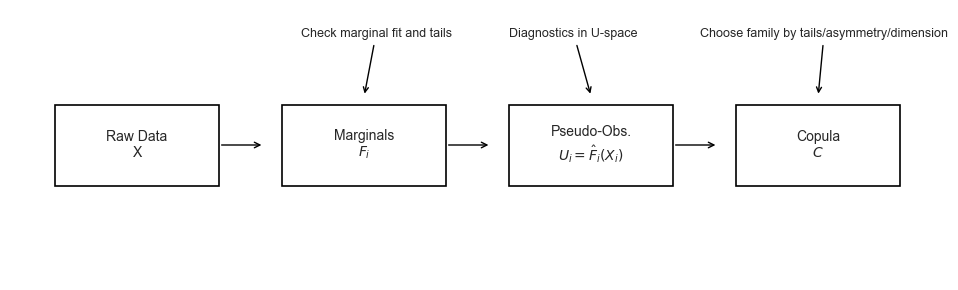

In [19]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")

def draw_box(ax, x, y, w, h, text):
    rect = plt.Rectangle((x, y), w, h, fill=False, lw=1.2)
    ax.add_patch(rect)
    ax.text(x + w / 2, y + h / 2, text, ha="center", va="center", fontsize=10)

draw_box(ax, 0.05, 0.35, 0.18, 0.3, "Raw Data\nX")
draw_box(ax, 0.3,  0.35, 0.18, 0.3, "Marginals\n$F_i$")
draw_box(ax, 0.55, 0.35, 0.18, 0.3, "Pseudo-Obs.\n$U_i = \\hat F_i(X_i)$")
draw_box(ax, 0.8,  0.35, 0.18, 0.3, "Copula\n$C$")

for start in [0.23, 0.48, 0.73]:
    ax.annotate("", xy=(start + 0.05, 0.5), xytext=(start, 0.5),
                arrowprops=dict(arrowstyle="->", lw=1))

ax.annotate("Check marginal fit and tails", xy=(0.39, 0.68), xytext=(0.32, 0.9),
            arrowprops=dict(arrowstyle="->"), fontsize=9)
ax.annotate("Diagnostics in U-space", xy=(0.64, 0.68), xytext=(0.55, 0.9),
            arrowprops=dict(arrowstyle="->"), fontsize=9)
ax.annotate("Choose family by tails/asymmetry/dimension", xy=(0.89, 0.68), xytext=(0.76, 0.9),
            arrowprops=dict(arrowstyle="->"), fontsize=9)

plt.tight_layout()
plt.savefig(out / "overview_pipeline.png", dpi=200)
plt.savefig(out / "overview_pipeline.svg")
plt.show()

# Sklar's Theorem — Figures and Demos


1. **Functional composition diagram** illustrating $F(x) = C(F_1(x_1), F_2(x_2))$.
2. **Gaussian copula density heatmap** as factorization intuition ($f_X = c(F) \cdot f_1 f_2$).
3. **IFM vs Pseudo-MLE demo** for estimating a Gaussian copula parameter from synthetic data with lognormal marginals.

In [25]:
def to_uniform_by_ranks(x: np.ndarray) -> np.ndarray:
    """Convert each column of x into empirical U(0,1) pseudo-observations via average ranks."""
    u = np.empty_like(x, dtype=float)
    for j in range(x.shape[1]):
        r = rankdata(x[:, j], method="average")
        u[:, j] = r / (len(x) + 1.0)
    return u

def gaussian_copula_density(u: np.ndarray, rho: float) -> np.ndarray:
    """Gaussian copula density c(u; rho) for 2D."""
    z = norm.ppf(u)
    z1, z2 = z[:, 0], z[:, 1]
    inv = 1.0 / (1 - rho**2)
    num = np.exp(-0.5 * inv * (z1**2 - 2*rho*z1*z2 + z2**2))
    den = np.exp(-0.5*(z1**2 + z2**2))
    c = inv**0.5 * num / den
    return c

def fit_lognormal_params(x: np.ndarray):
    """MLE for LogNormal(mu, sigma): ln X ~ N(mu, sigma^2). Returns (shape, loc, scale) for scipy."""
    y = np.log(x)
    mu = np.mean(y)
    sigma = np.std(y, ddof=1)
    return sigma, 0.0, np.exp(mu)

def ifm_gaussian_copula_rho(x: np.ndarray) -> float:
    """IFM for Gaussian copula rho in 2D using lognormal marginals."""
    u = np.zeros_like(x, dtype=float)
    for j in range(2):
        s, loc, sc = fit_lognormal_params(x[:, j])
        u[:, j] = lognorm.cdf(x[:, j], s=s, loc=loc, scale=sc)
    z = norm.ppf(u)
    return float(np.corrcoef(z.T)[0, 1])

def pseudo_mle_gaussian_copula_rho(x: np.ndarray) -> float:
    """Pseudo-MLE for Gaussian copula rho in 2D via empirical ranks."""
    u = to_uniform_by_ranks(x)
    z = norm.ppf(u)
    return float(np.corrcoef(z.T)[0, 1])

## Figure 1 — Functional Composition (Sklar)

Schematic showing how marginals map raw data to probability scale and the copula stitches the components:
$F(x_1, x_2) = C(F_1(x_1), F_2(x_2))$.

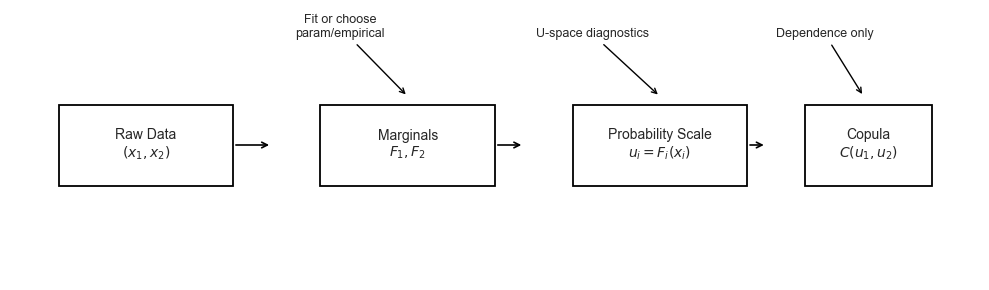

In [26]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")

def draw_box(ax, x, y, w, h, text):
    rect = plt.Rectangle((x, y), w, h, fill=False, lw=1.3)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha="center", va="center", fontsize=10)

draw_box(ax, 0.05, 0.35, 0.18, 0.3, "Raw Data\n$(x_1, x_2)$")
draw_box(ax, 0.32, 0.35, 0.18, 0.3, "Marginals\n$F_1, F_2$")
draw_box(ax, 0.58, 0.35, 0.18, 0.3, "Probability Scale\n$u_i = F_i(x_i)$")
draw_box(ax, 0.82, 0.35, 0.13, 0.3, "Copula\n$C(u_1,u_2)$")

ax.annotate("", xy=(0.27, 0.5), xytext=(0.23, 0.5), arrowprops=dict(arrowstyle="->", lw=1.2))
ax.annotate("", xy=(0.53, 0.5), xytext=(0.50, 0.5), arrowprops=dict(arrowstyle="->", lw=1.2))
ax.annotate("", xy=(0.78, 0.5), xytext=(0.76, 0.5), arrowprops=dict(arrowstyle="->", lw=1.2))

ax.annotate("Fit or choose\nparam/empirical", xy=(0.41, 0.68), xytext=(0.34, 0.9), arrowprops=dict(arrowstyle="->"), fontsize=9, ha="center")
ax.annotate("U-space diagnostics", xy=(0.67, 0.68), xytext=(0.60, 0.9), arrowprops=dict(arrowstyle="->"), fontsize=9, ha="center")
ax.annotate("Dependence only", xy=(0.88, 0.68), xytext=(0.84, 0.9), arrowprops=dict(arrowstyle="->"), fontsize=9, ha="center")

plt.tight_layout()
plt.savefig(out / "sklar_functional_composition.png", dpi=200)
plt.savefig(out / "sklar_functional_composition.svg")
plt.show()

## Figure 2 — Gaussian Copula Density Heatmap

A heatmap of the Gaussian copula density $c(u_1,u_2;\rho)$ illustrates how the joint density factorizes:
$f_X(x) = c(F_1(x_1), F_2(x_2)) \cdot f_1(x_1) f_2(x_2)$.

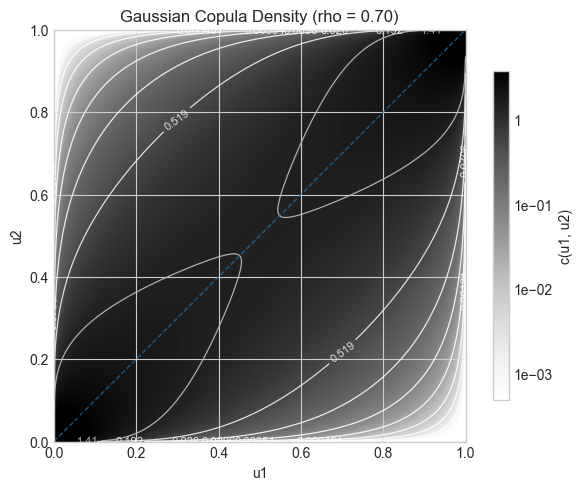

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter
# assumes gaussian_copula_density(U, rho) is already defined

# --- Parameters ---
rho = 0.7
grid = 500
u1 = np.linspace(1e-4, 1 - 1e-4, grid)
u2 = np.linspace(1e-4, 1 - 1e-4, grid)
U1, U2 = np.meshgrid(u1, u2)
U = np.column_stack([U1.ravel(), U2.ravel()])

# --- Density ---
c = gaussian_copula_density(U, rho=rho).reshape(grid, grid)

# Robust contrast stretch (avoid outliers killing contrast)
p1, p99 = np.percentile(c, [1, 99])
vmin = max(p1, 1e-6)   # safety bound for LogNorm
vmax = p99

fig, ax = plt.subplots(figsize=(6.2, 5.0))

# Heatmap with log scaling to enhance weak variations
im = ax.imshow(
    c, origin="lower", extent=[0, 1, 0, 1], aspect="equal",
    norm=LogNorm(vmin=vmin, vmax=vmax)
)

# Geometric contour levels between vmin and vmax
levels = np.geomspace(vmin, vmax, num=10)
cs = ax.contour(U1, U2, c, levels=levels, linewidths=0.9, alpha=0.9)
ax.clabel(cs, inline=True, fontsize=8, fmt="%.3g")

# Diagonal reference (positive dependence)
ax.plot([0,1], [0,1], linestyle="--", linewidth=1, alpha=0.7)

ax.set_title(f"Gaussian Copula Density (rho = {rho:.2f})")
ax.set_xlabel("u1"); ax.set_ylabel("u2")

# Colorbar in log scale
cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("c(u1, u2)")
# optional: nicer tick formatting for log scale
cbar.formatter = LogFormatter(10, labelOnlyBase=False)
cbar.update_ticks()

plt.tight_layout()
# choose your output directory; here we just save next to the notebook
plt.savefig(out / "gaussian_copula_density_heatmap.png", dpi=240)
plt.savefig(out / "gaussian_copula_density_heatmap.svg")
plt.show()


## Figure 3 — IFM vs Pseudo-MLE (Gaussian Copula, Lognormal Marginals)

We simulate bivariate data with a Gaussian copula (true $\rho=0.6$) and lognormal marginals.
Then we estimate $\rho$ via:
- **IFM**: fit lognormal marginals (MLE) → compute $U$ via fitted $F_i$ → MLE on normal scores.
- **Pseudo-MLE**: compute $U$ via empirical ranks → MLE on normal scores.

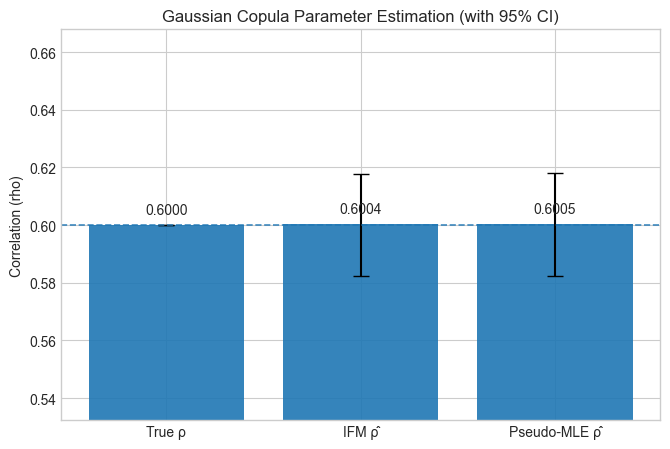

True rho     : 0.600000
IFM  rho_hat : 0.600354  (Fisher 95% CI: 0.582325, 0.617792)
PML  rho_hat : 0.600483  (Fisher 95% CI: 0.582458, 0.617917)


C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\3786622781.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\3786622781.py:171: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.savefig(out / "normal_scores_scatter_pml.png", dpi=220)
C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\3786622781.py:172: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.savefig(out / "normal_scores_scatter_pml.svg")
c:\Users\jvvce\github_repositories\copula-lab\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


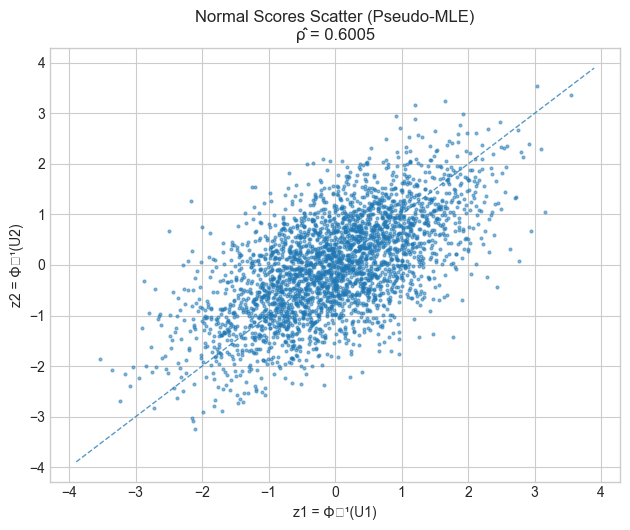

In [38]:
# --- Gaussian copula: IFM vs Pseudo-MLE with clear diagnostics ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm, lognorm, rankdata, multivariate_normal

# Reproducibility
np.random.seed(42)

# --------- Utilities ---------
def clip01(u, eps=1e-12):
    """Clip to (eps, 1-eps) to avoid +/-inf when applying norm.ppf."""
    return np.clip(u, eps, 1 - eps)

def to_uniform_by_ranks(x: np.ndarray) -> np.ndarray:
    """Empirical U(0,1) via average ranks, column-wise."""
    u = np.empty_like(x, dtype=float)
    for j in range(x.shape[1]):
        r = rankdata(x[:, j], method="average")
        u[:, j] = r / (len(x) + 1.0)
    return u

def fit_lognormal_params(x: np.ndarray):
    """
    MLE for LogNormal(mu, sigma) with loc=0.  If X~LogN(mu, sigma^2), ln X ~ N(mu, sigma^2).
    Returns (shape=sigma, loc=0.0, scale=exp(mu)) compatible with scipy.lognorm.
    """
    y = np.log(x)
    mu = np.mean(y)
    sigma = np.std(y, ddof=1)
    return sigma, 0.0, np.exp(mu)

def ifm_gaussian_copula_rho(x: np.ndarray) -> float:
    """
    IFM estimate of rho for Gaussian copula (2D) with lognormal marginals.
    1) Fit each marginal (lognormal) -> get F_i
    2) U_i = F_i(x_i)
    3) z_i = Phi^{-1}(U_i); rho_hat = Corr(z)
    """
    u = np.zeros_like(x, dtype=float)
    for j in range(2):
        s, loc, sc = fit_lognormal_params(x[:, j])
        u[:, j] = lognorm.cdf(x[:, j], s=s, loc=loc, scale=sc)
    z = norm.ppf(clip01(u))
    return float(np.corrcoef(z.T)[0, 1])

def pseudo_mle_gaussian_copula_rho(x: np.ndarray) -> float:
    """
    Pseudo-MLE estimate of rho for Gaussian copula (2D).
    1) U via empirical ranks
    2) z = Phi^{-1}(U); rho_hat = Corr(z)
    """
    u = to_uniform_by_ranks(x)
    z = norm.ppf(clip01(u))
    return float(np.corrcoef(z.T)[0, 1])

def fisher_ci(r: float, n: int, alpha: float = 0.05):
    """
    Fisher z-transformation CI for correlation.
    z = atanh(r), se = 1/sqrt(n-3).
    Returns (lo, hi) on the original correlation scale.
    """
    z = np.arctanh(np.clip(r, -0.999999, 0.999999))
    se = 1.0 / np.sqrt(max(n - 3, 1))
    z_lo = z - norm.ppf(1 - alpha/2) * se
    z_hi = z + norm.ppf(1 - alpha/2) * se
    return np.tanh(z_lo), np.tanh(z_hi)

def bootstrap_ci(estimator, x: np.ndarray, B: int = 1000, alpha: float = 0.05, block=None, rng=None):
    """
    Nonparametric bootstrap CI for an estimator(x)->scalar.
    If 'block' is None, simple iid bootstrap.
    """
    rng = np.random.default_rng(None if rng is None else rng)
    n = len(x)
    vals = np.empty(B, dtype=float)
    for b in range(B):
        idx = rng.integers(0, n, n)
        vals[b] = estimator(x[idx, :])
    lo = np.quantile(vals, alpha/2)
    hi = np.quantile(vals, 1 - alpha/2)
    return float(lo), float(hi), vals

# --------- Simulate data with known true rho ---------
n = 5000
true_rho = 0.6
cov = np.array([[1.0, true_rho], [true_rho, 1.0]])

# Copula: Gaussian -> u = Phi(z)
z = multivariate_normal(mean=[0, 0], cov=cov).rvs(size=n)
u = norm.cdf(z)  # U ~ Gaussian copula (with correlation true_rho)

# Lognormal marginals (heterogeneous)
mu1, sigma1 = 0.2, 0.6
mu2, sigma2 = -0.1, 0.9
x1 = np.exp(mu1 + sigma1 * norm.ppf(clip01(u[:, 0])))
x2 = np.exp(mu2 + sigma2 * norm.ppf(clip01(u[:, 1])))
x = np.column_stack([x1, x2])

# --------- Estimates ---------
rho_ifm = ifm_gaussian_copula_rho(x)
rho_pml = pseudo_mle_gaussian_copula_rho(x)

# Analytic 95% CI (Fisher) using normal scores sample size
ci_ifm = fisher_ci(rho_ifm, n)
ci_pml = fisher_ci(rho_pml, n)

# (Optional) Bootstrap 95% CI (comment out if you don't need it)
# ci_ifm_boot, ci_pml_boot = bootstrap_ci(ifm_gaussian_copula_rho, x)[0:2], bootstrap_ci(pseudo_mle_gaussian_copula_rho, x)[0:2]


# --------- Figure A: Bar chart with 95% CI and reference line ---------
fig, ax = plt.subplots(figsize=(6.8, 4.6))

labels = ["True ρ", "IFM ρ̂", "Pseudo-MLE ρ̂"]
vals   = [true_rho, rho_ifm, rho_pml]

# Error bars only for estimates (None for true)
yerr = [0.0,
        max(rho_ifm - ci_ifm[0], 0.0),    # upper half-width for plotting (symmetric drawn below)
        max(rho_pml - ci_pml[0], 0.0)]
# Matplotlib needs symmetric yerr; compute half-widths
yerr_sym = np.array([
    [0.0, rho_ifm - ci_ifm[0], rho_pml - ci_pml[0]],   # lower
    [0.0, ci_ifm[1] - rho_ifm, ci_pml[1] - rho_pml]    # upper
])

bars = ax.bar(labels, vals, alpha=0.9, yerr=yerr_sym, capsize=6)

# Reference line at true rho
ax.axhline(true_rho, linestyle="--", linewidth=1.2, alpha=0.85)

# Tight y-range around values for contrast
lower = max(0.0, min(vals + [ci_ifm[0], ci_pml[0]]) - 0.05)
upper = min(1.0, max(vals + [ci_ifm[1], ci_pml[1]]) + 0.05)
ax.set_ylim(lower, upper)

# Numeric labels on top of bars
for b, v in zip(bars, vals):
    ax.text(b.get_x() + b.get_width()/2, v + (upper-lower)*0.02, f"{v:.4f}",
            ha="center", va="bottom", fontsize=10)

ax.set_title("Gaussian Copula Parameter Estimation (with 95% CI)")
ax.set_ylabel("Correlation (rho)")
plt.tight_layout()
plt.savefig(out / "ifm_vs_pseudomle_bar_CI.png", dpi=220)
plt.savefig(out / "ifm_vs_pseudomle_bar_CI.svg")
plt.show()

print(f"True rho     : {true_rho:.6f}")
print(f"IFM  rho_hat : {rho_ifm:.6f}  (Fisher 95% CI: {ci_ifm[0]:.6f}, {ci_ifm[1]:.6f})")
print(f"PML  rho_hat : {rho_pml:.6f}  (Fisher 95% CI: {ci_pml[0]:.6f}, {ci_pml[1]:.6f})")

# --------- Figure B: Diagnostic scatter of normal scores ---------
# Build z from each approach (they are almost identical in this setup)
# For visualization, we use PML z (ranks) to avoid marginal modeling assumptions.
u_pml = to_uniform_by_ranks(x)
z_pml = norm.ppf(clip01(u_pml))

fig2, ax2 = plt.subplots(figsize=(6.4, 5.4))
# Subsample for legibility if needed
idx = np.random.choice(len(z_pml), size=3000, replace=False)
ax2.scatter(z_pml[idx, 0], z_pml[idx, 1], s=4, alpha=0.5)
ax2.set_title(f"Normal Scores Scatter (Pseudo-MLE)\nρ̂ = {rho_pml:.4f}")
ax2.set_xlabel("z1 = Φ⁻¹(U1)"); ax2.set_ylabel("z2 = Φ⁻¹(U2)")
# Diagonal reference
lims = np.array([ax2.get_xlim(), ax2.get_ylim()])
lo, hi = np.min(lims), np.max(lims)
ax2.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1, alpha=0.75)
plt.tight_layout()
plt.savefig(out / "normal_scores_scatter_pml.png", dpi=220)
plt.savefig(out / "normal_scores_scatter_pml.svg")
plt.show()


# 03 — Rank-based measures
This section visualizes the analytic relation between Kendall’s $\tau$ and Pearson $\rho$ in elliptical families, and validates it with Gaussian simulations.


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kendalltau, spearmanr, rankdata, multivariate_normal

def gaussian_copula_sample(n: int, rho: float, seed: int = 7):
    """Return U ~ Gaussian copula with correlation rho (2D)."""
    rng = np.random.default_rng(seed)
    cov = np.array([[1.0, rho], [rho, 1.0]])
    z = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n)
    u = norm.cdf(z)
    return u

def empirical_tau_spearman(u: np.ndarray):
    """Compute Kendall's tau and Spearman's rho_s from U-space data."""
    tau = kendalltau(u[:, 0], u[:, 1], method="auto")[0]
    rho_s = spearmanr(u[:, 0], u[:, 1])[0]
    return float(tau), float(rho_s)

## Figure 1 — U-Space Scatter at Different Pearson ρ

Scatter plots in U-space for Gaussian copulas with ρ ∈ {0.2, 0.6, 0.9}.
Titles include empirical Kendall's τ and Spearman's ρₛ.

[info] Saving figures to: C:\Users\jvvce\github_repositories\copula-lab\docs\assets\figures\01_foundations


C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\1927323990.py:36: UserWarning: Glyph 8347 (\N{LATIN SUBSCRIPT SMALL LETTER S}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\1927323990.py:41: UserWarning: Glyph 8347 (\N{LATIN SUBSCRIPT SMALL LETTER S}) missing from font(s) Arial.
  fig.savefig(png_path, dpi=220)
C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\1927323990.py:42: UserWarning: Glyph 8347 (\N{LATIN SUBSCRIPT SMALL LETTER S}) missing from font(s) Arial.
  fig.savefig(svg_path)
c:\Users\jvvce\github_repositories\copula-lab\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8347 (\N{LATIN SUBSCRIPT SMALL LETTER S}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


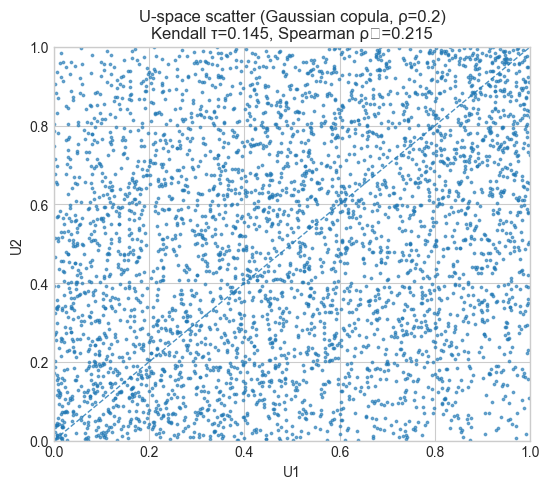

[saved] rank_scatter_rho_0_2.png, rank_scatter_rho_0_2.svg


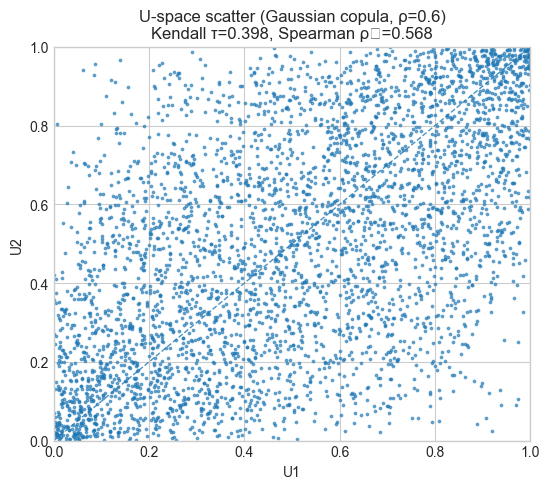

[saved] rank_scatter_rho_0_6.png, rank_scatter_rho_0_6.svg


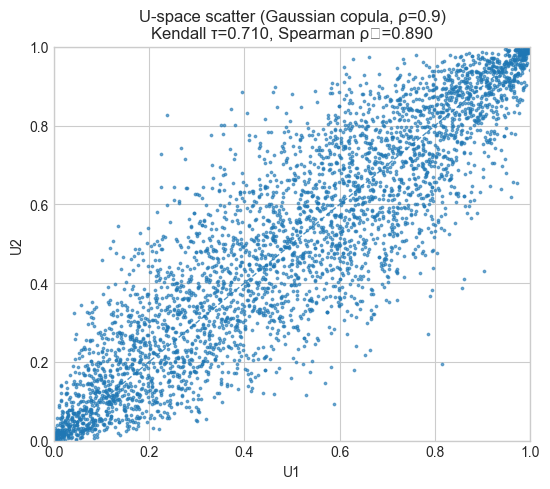

[saved] rank_scatter_rho_0_9.png, rank_scatter_rho_0_9.svg


In [46]:
# --- Robust version of rank scatter plotting ---
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr

# Output directory (relative to notebook)
fig_dir = Path("..")/ "docs" / "assets" / "figures" / "01_foundations"
try:
    fig_dir.mkdir(parents=True, exist_ok=True)
    print(f"[info] Saving figures to: {fig_dir.resolve()}")
except Exception as e:
    print(f"[warn] Cannot create {fig_dir} ({e}), using fallback './figures_local'")
    fig_dir = Path("figures_local")
    fig_dir.mkdir(parents=True, exist_ok=True)

def plot_rank_scatter(u: np.ndarray, rho: float, out_prefix: str):
    """Plot U-space scatter and save PNG/SVG files safely."""
    # Compute empirical measures
    tau = kendalltau(u[:, 0], u[:, 1], method="auto")[0]
    rho_s = spearmanr(u[:, 0], u[:, 1])[0]
    
    # Plot
    fig, ax = plt.subplots(figsize=(5.6, 5.0))
    ax.scatter(u[:, 0], u[:, 1], s=3, alpha=0.6)
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1, alpha=0.8)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("U1")
    ax.set_ylabel("U2")
    ax.set_title(
        f"U-space scatter (Gaussian copula, ρ={rho:.1f})\n"
        f"Kendall τ={tau:.3f}, Spearman ρₛ={rho_s:.3f}"
    )
    plt.tight_layout()

    # Safe saving
    png_path = fig_dir / f"{out_prefix}.png"
    svg_path = fig_dir / f"{out_prefix}.svg"
    fig.savefig(png_path, dpi=220)
    fig.savefig(svg_path)
    plt.show()

    print(f"[saved] {png_path.name}, {svg_path.name}")
    return float(tau), float(rho_s)

# Example execution
for rho in [0.2, 0.6, 0.9]:
    u = gaussian_copula_sample(n=4000, rho=rho, seed=42 + int(rho * 10))
    prefix = f"rank_scatter_rho_{str(rho).replace('.', '_')}"
    plot_rank_scatter(u, rho, prefix)


## Figure 2 — Kendall's τ and Spearman's ρₛ vs Pearson ρ (Gaussian Copula)

Theoretical curves and empirical validation from simulated samples.

[info] Saving figures to: C:\Users\jvvce\github_repositories\copula-lab\docs\assets\figures\01_foundations


C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\988688378.py:63: UserWarning: Glyph 8347 (\N{LATIN SUBSCRIPT SMALL LETTER S}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\988688378.py:66: UserWarning: Glyph 8347 (\N{LATIN SUBSCRIPT SMALL LETTER S}) missing from font(s) Arial.
  fig.savefig(fig_png, dpi=220)
C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\988688378.py:67: UserWarning: Glyph 8347 (\N{LATIN SUBSCRIPT SMALL LETTER S}) missing from font(s) Arial.
  fig.savefig(fig_svg)
c:\Users\jvvce\github_repositories\copula-lab\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8347 (\N{LATIN SUBSCRIPT SMALL LETTER S}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


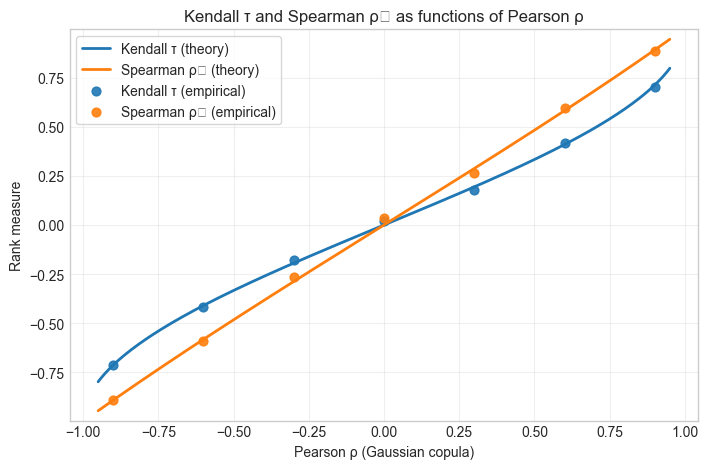

[saved] ..\docs\assets\figures\01_foundations\tau_rhos_vs_pearson_curve.png, tau_rhos_vs_pearson_curve.svg


In [47]:
# --- Kendall's tau & Spearman's rho_s vs Pearson rho (robust, self-contained) ---
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kendalltau, spearmanr

# Provide gaussian_copula_sample if not already defined in this kernel
try:
    gaussian_copula_sample
except NameError:
    def gaussian_copula_sample(n: int, rho: float, seed: int = 7):
        """Return U ~ Gaussian copula with correlation rho (2D)."""
        rng = np.random.default_rng(seed)
        cov = np.array([[1.0, rho], [rho, 1.0]])
        z = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n)
        return norm.cdf(z)

# Output directory (prefer ../assets/figures/01_foundations; fallback to ./figures_local)
fig_dir = Path("..") / "docs" / "assets" / "figures" / "01_foundations"
try:
    fig_dir.mkdir(parents=True, exist_ok=True)
    out_dir = fig_dir
    print(f"[info] Saving figures to: {out_dir.resolve()}")
except Exception as e:
    print(f"[warn] Cannot create {fig_dir} ({e}). Falling back to ./figures_local")
    out_dir = Path("figures_local")
    out_dir.mkdir(parents=True, exist_ok=True)
    print(f"[info] Saving figures to: {out_dir.resolve()}")

# Theoretical curves
r_grid = np.linspace(-0.95, 0.95, 241)
tau_theory  = (2/np.pi) * np.arcsin(r_grid)     # Kendall's tau (Gaussian copula)
rhos_theory = (6/np.pi) * np.arcsin(r_grid/2)   # Spearman's rho_s (Gaussian copula)

# Empirical validation points
r_probe = np.array([-0.9, -0.6, -0.3, 0.0, 0.3, 0.6, 0.9])
tau_emp, rhos_emp = [], []
for r in r_probe:
    U = gaussian_copula_sample(n=5000, rho=float(r), seed=123 + int((r + 1) * 10))
    t  = kendalltau(U[:, 0], U[:, 1], method="auto")[0]
    rs = spearmanr(U[:, 0], U[:, 1])[0]
    tau_emp.append(float(t))
    rhos_emp.append(float(rs))

# Plot
fig, ax = plt.subplots(figsize=(7.2, 4.8))
ax.plot(r_grid, tau_theory,  lw=2.0, label="Kendall τ (theory)")
ax.plot(r_grid, rhos_theory, lw=2.0, label="Spearman ρₛ (theory)")
ax.scatter(r_probe, tau_emp,  s=40, alpha=0.9, label="Kendall τ (empirical)")
ax.scatter(r_probe, rhos_emp, s=40, alpha=0.9, label="Spearman ρₛ (empirical)")
ax.set_xlabel("Pearson ρ (Gaussian copula)")
ax.set_ylabel("Rank measure")
ax.set_title("Kendall τ and Spearman ρₛ as functions of Pearson ρ")
ax.legend(frameon=True)
ax.grid(True, alpha=0.3)

# Make the y-range tight for visual contrast (optional)
ymin = min(np.min(tau_theory), np.min(rhos_theory), np.min(tau_emp), np.min(rhos_emp)) - 0.05
ymax = max(np.max(tau_theory), np.max(rhos_theory), np.max(tau_emp), np.max(rhos_emp)) + 0.05
ax.set_ylim(ymin, ymax)

plt.tight_layout()
(fig_png := out_dir / "tau_rhos_vs_pearson_curve.png")
(fig_svg := out_dir / "tau_rhos_vs_pearson_curve.svg")
fig.savefig(fig_png, dpi=220)
fig.savefig(fig_svg)
plt.show()
print(f"[saved] {fig_png}, {fig_svg.name}")


# Tail Dependence — Figures and Demos

This section accompanies the **Tail Dependence** section. It provides:
1. **Heatmaps in the upper-right corner** for Gaussian vs t copulas.
2. **Empirical upper-tail dependence** λ_U(q) vs q with theoretical line for t copula.
3. **λ_U vs ν curve** for the t copula at fixed ρ.

In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import t as tdist, norm

# -------------------- Paths --------------------
# Prefer ../assets/figures/01_foundations with robust fallback
def get_outdir():
    candidates = [
        Path("..") / 'docs' / "assets" / "figures" / "01_foundations",
        Path("assets") / "figures" / "01_foundations",
        Path("figures")
    ]
    for d in candidates:
        try:
            d.mkdir(parents=True, exist_ok=True)
            test = d / ".write_test"
            with open(test, "w", encoding="utf-8") as f:
                f.write("ok")
            test.unlink()
            print(f"[info] Using output dir: {d.resolve()}")
            return d
        except Exception as e:
            print(f"[warn] Cannot use {d}: {e}")
    raise RuntimeError("No writable output directory.")

OUTDIR = get_outdir()

# -------------------- Helpers --------------------
def sample_t_copula(n: int, rho: float, nu: int, seed: int = 7):
    rng = np.random.default_rng(seed)
    cov = np.array([[1.0, rho], [rho, 1.0]])
    z = rng.multivariate_normal(mean=[0.0, 0.0], cov=cov, size=n)
    s = rng.chisquare(df=nu, size=n)
    tvec = z / np.sqrt(s / nu)[:, None]
    u = np.column_stack([tdist.cdf(tvec[:,0], df=nu),
                         tdist.cdf(tvec[:,1], df=nu)])
    return u

def sample_gaussian_copula(n: int, rho: float, seed: int = 42):
    rng = np.random.default_rng(seed)
    cov = np.array([[1.0, rho], [rho, 1.0]])
    z = rng.multivariate_normal(mean=[0.0, 0.0], cov=cov, size=n)
    return norm.cdf(z)

def heat_density(u, bins=120, corner="upper"):
    import numpy as np
    H, xedges, yedges = np.histogram2d(u[:,0], u[:,1],
                                       bins=bins, range=[[0,1],[0,1]], density=True)
    H = H.T
    if corner == "upper":
        ix = int(0.7 * bins)
        mask = np.zeros_like(H, dtype=bool)
        mask[ix:, ix:] = True
        H_vis = np.where(mask, H, np.nan)
    elif corner == "lower":
        ix = int(0.3 * bins)
        mask = np.zeros_like(H, dtype=bool)
        mask[:ix, :ix] = True
        H_vis = np.where(mask, H, np.nan)
    else:
        H_vis = H
    return H, H_vis

def lambda_upper_emp(U, q):
    n = U.shape[0]
    num = np.sum((U[:,0] > q) & (U[:,1] > q))
    den = max(1, np.sum(U[:,0] > q))
    return num / den

def t_copula_lambda_u(rho, nu):
    arg = -np.sqrt((nu + 1.0) * (1.0 - rho) / (1.0 + rho))
    return 2.0 * tdist.cdf(arg, df=nu + 1.0)

[info] Using output dir: C:\Users\jvvce\github_repositories\copula-lab\docs\assets\figures\01_foundations


## Figure 1 — Corner Heatmaps (Upper-Right)

Visual comparison of tail concentration: Gaussian (no tail dependence) vs t-copula (positive tail dependence).

[info] Using: C:\Users\jvvce\github_repositories\copula-lab\docs\assets\figures\01_foundations


C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\2741711318.py:90: UserWarning: Glyph 8658 (\N{RIGHTWARDS DOUBLE ARROW}) missing from font(s) Arial.
  fig.tight_layout()
C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\2741711318.py:91: UserWarning: Glyph 8658 (\N{RIGHTWARDS DOUBLE ARROW}) missing from font(s) Arial.
  fig.savefig(OUTDIR/"tail_lift_gauss_vs_t.png", dpi=220)
C:\Users\jvvce\AppData\Local\Temp\ipykernel_13712\2741711318.py:92: UserWarning: Glyph 8658 (\N{RIGHTWARDS DOUBLE ARROW}) missing from font(s) Arial.
  fig.savefig(OUTDIR/"tail_lift_gauss_vs_t.svg")


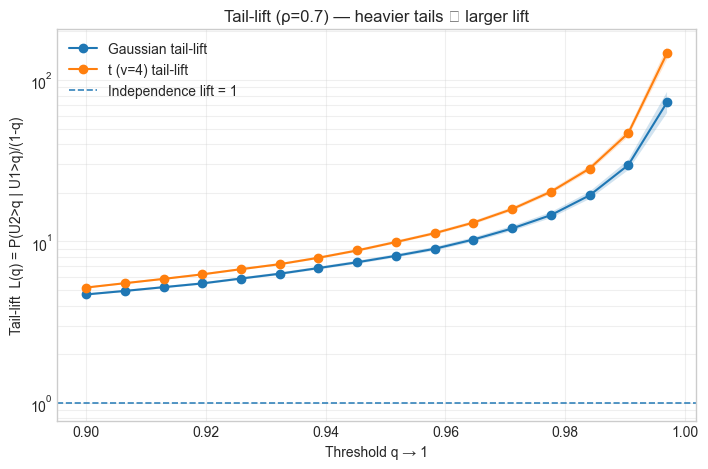

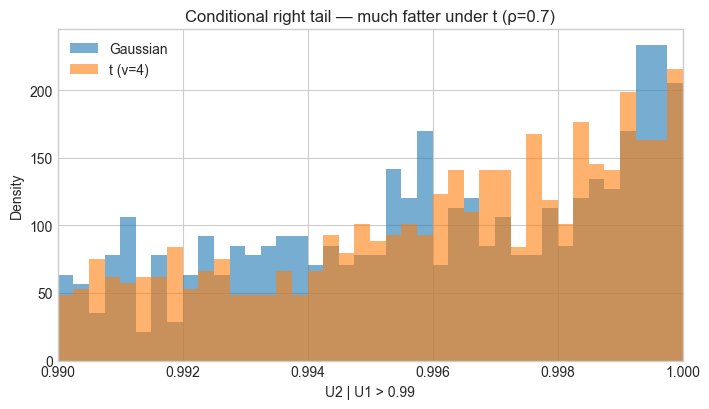

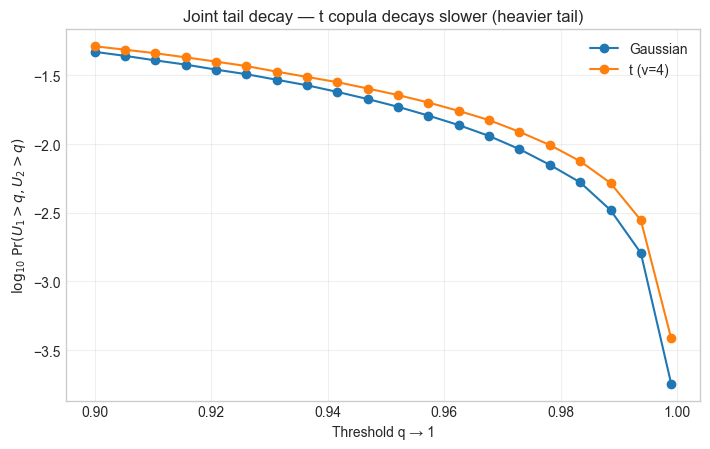

In [56]:
# === Tail dependence diagnostics that "pop" ===
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t as tdist

# ---------------- Paths (robust) ----------------
def get_outdir():
    candidates = [
        Path("..")/"docs"/"assets"/"figures"/"01_foundations",
        Path("assets")/"figures"/"01_foundations",
        Path("figures")
    ]
    for d in candidates:
        try:
            d.mkdir(parents=True, exist_ok=True)
            (d/".write_test").write_text("ok", encoding="utf-8")
            (d/".write_test").unlink()
            print("[info] Using:", d.resolve())
            return d
        except Exception as e:
            print("[warn]", d, "->", e)
    raise RuntimeError("No writable output directory.")
OUTDIR = get_outdir()

# --------------- Simulators ----------------
def sample_gaussian_copula(n: int, rho: float, seed: int = 1):
    rng = np.random.default_rng(seed)
    z = rng.multivariate_normal([0,0], [[1,rho],[rho,1]], size=n)
    return norm.cdf(z)

def sample_t_copula(n: int, rho: float, nu: int, seed: int = 2):
    rng = np.random.default_rng(seed)
    z = rng.multivariate_normal([0,0], [[1,rho],[rho,1]], size=n)
    s = rng.chisquare(df=nu, size=n)
    tvec = z / np.sqrt(s / nu)[:, None]
    return np.column_stack([tdist.cdf(tvec[:,0], df=nu),
                            tdist.cdf(tvec[:,1], df=nu)])

# --------------- Metrics ----------------
def lambda_upper_emp(U: np.ndarray, q: float):
    num = np.sum((U[:,0] > q) & (U[:,1] > q))
    den = np.sum(U[:,0] > q)
    return (num / den) if den > 0 else np.nan, num, den

def wilson_ci(num: int, den: int, alpha=0.05):
    # Wilson score interval for a proportion (numerically stable in tails)
    if den == 0:
        return (np.nan, np.nan)
    import math
    z = norm.ppf(1 - alpha/2)
    p = num / den
    denom = 1 + z**2/den
    center = (p + z**2/(2*den)) / denom
    half = z * math.sqrt((p*(1-p) + z**2/(4*den)) / den) / denom
    return center - half, center + half

# ---------- 1) Tail-lift curves with CIs ----------
def plot_tail_lift(Ug, Ut, nu, rho, qs=None):
    if qs is None:
        qs = np.linspace(0.90, 0.997, 16)
    lam_g, lam_t = [], []
    ci_g, ci_t = [], []
    for q in qs:
        lg, ng, dg = lambda_upper_emp(Ug, q)
        lt, nt, dt = lambda_upper_emp(Ut, q)
        lam_g.append(lg/(1-q))
        lam_t.append(lt/(1-q))
        lo_g, hi_g = wilson_ci(ng, dg)
        lo_t, hi_t = wilson_ci(nt, dt)
        ci_g.append(((lo_g/(1-q)), (hi_g/(1-q))))
        ci_t.append(((lo_t/(1-q)), (hi_t/(1-q))))

    lam_g = np.array(lam_g); lam_t = np.array(lam_t)
    lo_g = np.array([c[0] for c in ci_g]); hi_g = np.array([c[1] for c in ci_g])
    lo_t = np.array([c[0] for c in ci_t]); hi_t = np.array([c[1] for c in ci_t])

    fig, ax = plt.subplots(figsize=(7.2, 4.8))
    ax.plot(qs, lam_g, marker="o", label="Gaussian tail-lift")
    ax.fill_between(qs, lo_g, hi_g, alpha=0.2)
    ax.plot(qs, lam_t, marker="o", label=f"t (ν={nu}) tail-lift")
    ax.fill_between(qs, lo_t, hi_t, alpha=0.2)
    ax.axhline(1.0, ls="--", lw=1.2, alpha=0.9, label="Independence lift = 1")
    ax.set_yscale("log")
    ax.set_xlabel("Threshold q → 1")
    ax.set_ylabel("Tail-lift  L(q) = P(U2>q | U1>q)/(1-q)")
    ax.set_title(f"Tail-lift (ρ={rho:.1f}) — heavier tails ⇒ larger lift")
    ax.grid(True, which="both", alpha=0.3)
    ax.legend()
    fig.tight_layout()
    fig.savefig(OUTDIR/"tail_lift_gauss_vs_t.png", dpi=220)
    fig.savefig(OUTDIR/"tail_lift_gauss_vs_t.svg")
    plt.show()

# ---------- 2) Conditional U2 | U1>q0 ----------
def plot_conditional_u2(Ug, Ut, q0=0.99, bins=40, rho=0.7, nu=4):
    g_sel = Ug[Ug[:,0] > q0, 1]
    t_sel = Ut[Ut[:,0] > q0, 1]
    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    ax.hist(g_sel, bins=bins, range=(q0,1.0), alpha=0.6, density=True, label="Gaussian")
    ax.hist(t_sel, bins=bins, range=(q0,1.0), alpha=0.6, density=True, label=f"t (ν={nu})")
    ax.set_xlim(q0, 1.0)
    ax.set_xlabel(f"U2 | U1 > {q0}")
    ax.set_ylabel("Density")
    ax.set_title(f"Conditional right tail — much fatter under t (ρ={rho:.1f})")
    ax.legend()
    fig.tight_layout()
    fig.savefig(OUTDIR/"conditional_u2_u1gt_0_99.png", dpi=220)
    fig.savefig(OUTDIR/"conditional_u2_u1gt_0_99.svg")
    plt.show()

# ---------- 3) Joint exceedance decay ----------
def plot_joint_exceedance_decay(Ug, Ut, rho=0.7, nu=4):
    qs = np.linspace(0.90, 0.999, 20)
    pj_g, pj_t = [], []
    for q in qs:
        pj_g.append(np.mean((Ug[:,0] > q) & (Ug[:,1] > q)))
        pj_t.append(np.mean((Ut[:,0] > q) & (Ut[:,1] > q)))
    pj_g = np.array(pj_g); pj_t = np.array(pj_t)

    fig, ax = plt.subplots(figsize=(7.2, 4.6))
    ax.plot(qs, np.log10(pj_g + 1e-16), marker="o", label="Gaussian")
    ax.plot(qs, np.log10(pj_t + 1e-16), marker="o", label=f"t (ν={nu})")
    ax.set_xlabel("Threshold q → 1")
    ax.set_ylabel(r"$\log_{10}\, \Pr(U_1>q, U_2>q)$")
    ax.set_title("Joint tail decay — t copula decays slower (heavier tail)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    fig.savefig(OUTDIR/"tail_heatmaps_gauss_vs_t.png", dpi=220)
    fig.savefig(OUTDIR/"tail_heatmaps_gauss_vs_t.svg")
    plt.show()

# ===== Run all =====
rho, nu, n = 0.7, 4, 200_000
Ug = sample_gaussian_copula(n=n, rho=rho, seed=1)
Ut = sample_t_copula(n=n, rho=rho, nu=nu, seed=2)

plot_tail_lift(Ug, Ut, nu=nu, rho=rho)
plot_conditional_u2(Ug, Ut, q0=0.99, rho=rho, nu=nu)
plot_joint_exceedance_decay(Ug, Ut, rho=rho, nu=nu)


## Figure 2 — Empirical Upper-Tail Dependence

Estimates of $\lambda_U(q)=\mathbb{P}(U_2>q\mid U_1>q)$ as $q\to 1$, for Gaussian and t copulas.

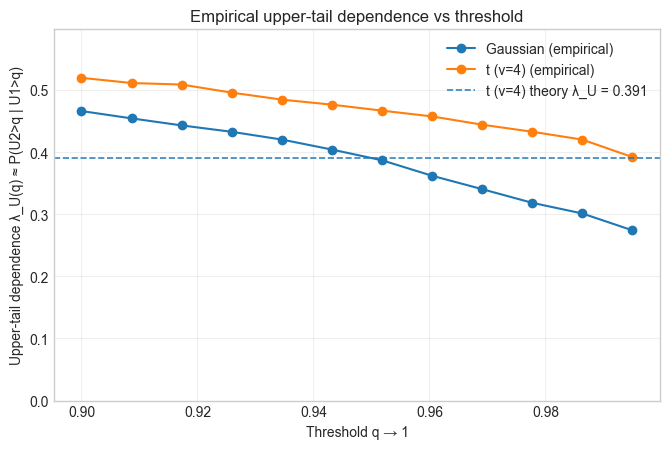

In [51]:
rho, nu = 0.7, 4
n = 120000
U_g = sample_gaussian_copula(n=n, rho=rho, seed=1)
U_t = sample_t_copula(n=n, rho=rho, nu=nu, seed=2)

qs = np.linspace(0.90, 0.995, 12)
lamU_g = [lambda_upper_emp(U_g, q) for q in qs]
lamU_t = [lambda_upper_emp(U_t, q) for q in qs]
lam_t_th = t_copula_lambda_u(rho=rho, nu=nu)

fig, ax = plt.subplots(figsize=(6.8, 4.6))
ax.plot(qs, lamU_g, marker="o", label="Gaussian (empirical)")
ax.plot(qs, lamU_t, marker="o", label=f"t (ν={nu}) (empirical)")
ax.axhline(lam_t_th, linestyle="--", linewidth=1.2, alpha=0.9,
           label=f"t (ν={nu}) theory λ_U = {lam_t_th:.3f}")
ax.set_xlabel("Threshold q → 1")
ax.set_ylabel("Upper-tail dependence λ_U(q) ≈ P(U2>q | U1>q)")
ax.set_title("Empirical upper-tail dependence vs threshold")
ax.set_ylim(0, max(0.05, max(lamU_t) * 1.15))
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(OUTDIR / "lambdaU_vs_q_gauss_vs_t.png", dpi=220)
plt.savefig(OUTDIR / "lambdaU_vs_q_gauss_vs_t.svg")
plt.show()

## Figure 3 — Theoretical $\lambda_U$ for the t Copula

Closed-form upper-tail dependence of the t copula as a function of degrees of freedom $\nu$ (fixed $\rho$).

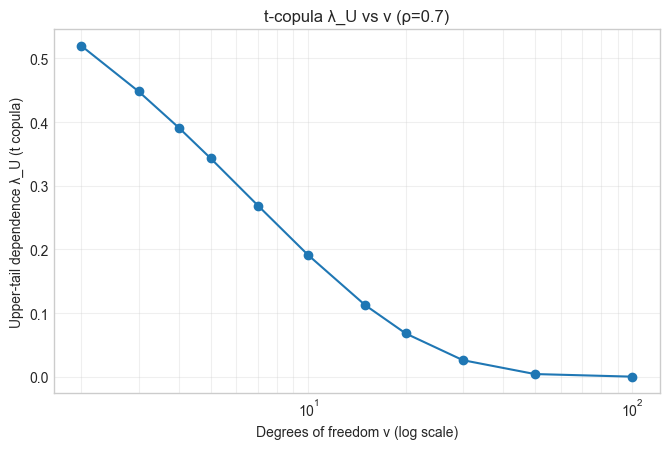

In [52]:
rho = 0.7
nus = np.array([2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 100])
lam_curve = [t_copula_lambda_u(rho=rho, nu=int(v)) for v in nus]

fig, ax = plt.subplots(figsize=(6.8, 4.6))
ax.plot(nus, lam_curve, marker="o")
ax.set_xscale("log")
ax.set_xlabel("Degrees of freedom ν (log scale)")
ax.set_ylabel("Upper-tail dependence λ_U (t copula)")
ax.set_title(f"t-copula λ_U vs ν (ρ={rho:.1f})")
ax.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.savefig(OUTDIR / "t_lambdaU_vs_nu_curve.png", dpi=220)
plt.savefig(OUTDIR / "t_lambdaU_vs_nu_curve.svg")
plt.show()